# EEG data analysis and visualization using mne-python lib

In [3]:
import numpy as np
import mne
import matplotlib.pyplot as plt
# picture presented by qt5 or inline
%matplotlib inline

## data loading

The dataset is from [BCI Competition IV 2a dataset](https://www.bbci.de/competition/iv/desc_2a.pdf)

This data set consists of EEG data from 9 subjects. The cue-based BCI paradigm consisted of four different motor imagery tasks, namely the imagination of movement of the `left hand (class 1)`, `right hand (class 2)`, `both feet (class 3)`, and `tongue (class 4)`. Two sessions on different days were recorded for each subject. Each session is comprised of 6 runs separated by short breaks. One run consists of 48 trials (12 for each of the four possible classes), yielding a total of 288 trials per session.

In [4]:
# the data set contains 18 .gdf files, we load A01T.gdf for example
dataset_path = "../../datasets/BCI_competition_IV_dataset/"
raw_data = mne.io.read_raw_gdf(dataset_path + "BCICIV_2a_gdf/A01T.gdf", eog=['EOG-left','EOG-central','EOG-right'], preload=True)
print("channels names: ", raw_data.info['ch_names'])

# the channels are 10-20system: "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz",
# "C2","C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz","EOG1", "EOG2", "EOG3"
# details: https://www.bbci.de/competition/iv/desc_2a.pdf
# rename the channels
mne.rename_channels(raw_data.info, {
    'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2':'FCz', 'EEG-3':'FC2',
    'EEG-4': 'FC4', 'EEG-5': 'C5','EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz',
    'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10':'CP1',
    'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'P1', 'EEG-Pz': 'Pz',
    'EEG-15':'P2', 'EEG-16':'POz'})
print("new channels name: ", raw_data.info['ch_names'])

# set montage of the channels
easycap_montage = mne.channels.make_standard_montage('standard_1020')
easycap_montage.plot()
raw_data.set_montage(easycap_montage)
raw_data.plot_sensors(show_names=True)

# get raw data info
print("raw data information: ", raw_data.info)

Extracting EDF parameters from C:\Users\xialugui\PycharmProjects\datasets\BCI_competition_IV_dataset\BCICIV_2a_gdf\A01T.gdf...
GDF file detected


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\xialugui\\PycharmProjects\\datasets\\BCI_competition_IV_dataset\\BCICIV_2a_gdf\\A01T.gdf'

## data visualization for example

We extract 10-30s eeg data in channels EEG-Fz and EEG-Cz and plot it for example.

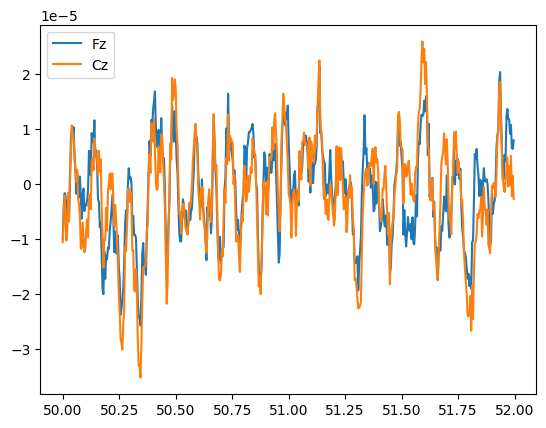

In [3]:
# use sample frequent to get index
sample_freq = raw_data.info['sfreq']
start_stop_second = np.array([50, 52])
start_sample, stop_sample = (start_stop_second * sample_freq).astype(int)
selected_channel_names = ['Fz', 'Cz']
selected_data = raw_data[selected_channel_names, start_sample:stop_sample]

# selected_data[0] is the time sequence, [1] is the value of voltage
x = selected_data[1]
y = selected_data[0].T

# plot the eeg data for example
lines = plt.plot(x, y)
plt.legend(lines, selected_channel_names)

## get events envolved in analysis

The position of an event in samples is contained in h.EVENT.POS. The corresponding type can be found in h.EVENT.TYP, and the duration of that particular event is stored in h.EVENT.DUR.EVENT.POS is the start of event, EVENT.TYP is type of event, EVENT.DUR is the duration of the event.

annotation info: <Annotations | 603 segments: 1023 (15), 1072 (1), 276 (1), 277 (1), 32766 ...>
annotation duration:  [4.00000e-03 1.18728e+02 4.00000e-03 8.10840e+01 4.00000e-03 1.66248e+02
 4.00000e-03 7.50000e+00 1.25200e+00]
annotation description:  {'768', '769', '770', '772', '771', '276', '1072', '277', '32766', '1023'}
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
events:  [[    0     0     5]
 [    0     0     3]
 [29683     0     5]
 [29683     0     4]
 [49955     0     5]]
event dict:  {'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}


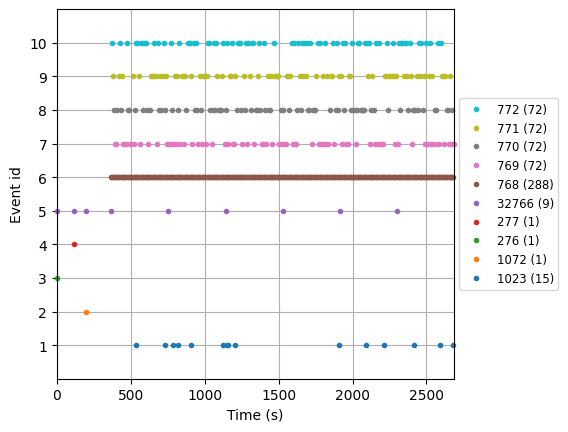

In [4]:
# get the annotations(events) from raw data
print("annotation info:", raw_data.annotations)
print("annotation duration: ", raw_data.annotations.duration[:9])
print("annotation description: ", set(raw_data.annotations.description))

# Here is the description of every type:
# 'Rejected trial':1023,
# 'Eye movements':1072,
# 'Idling EEG (eyes open)':276,
# 'Idling EEG (eyes closed)':277,
# 'Start of a new run':32766,
# 'Start of a trial':768,
# *'Cue onset left (class 1)':769,
# *'Cue onset right (class 2)':770,
# *'Cue onset foot (class 3)':771,
# *'Cue onset tongue (class 4)':772

# get events from annotations
events, events_dict = mne.events_from_annotations(raw_data)
print("events: ", events[:5])
print("event dict: ", events_dict)
# event_dict is default to int from [1,n] n is the number of events

# visual the event distributed
events_fig = mne.viz.plot_events(events, sfreq=raw_data.info['sfreq'], first_samp=raw_data.first_samp, event_id=events_dict)

## visualization of spectral density and scalp topography

In [5]:
%matplotlib qt5
# psd figure
spectrum = raw_data.compute_psd()
spectrum.plot(average=True)

# plot all channel
spectrum.plot()

# scalp topography
spectrum.plot_topomap()
plt.cla()

Effective window size : 1.024 (s)
